# READ ME

This notebook reproduces the results and figures of the Steiner Tree analysis of Belyaeva et al. (2020). The reader may also adapt the code to their specific use case if they want to conduct a drug repurposing analysis in the spirit of Belyaeva et al. Before adapting the notebook to your problem, we recommend that you fully run it using the data of Belyaeva et al. in order to familiarize yourself with the main steps and the data format/structures.

In order to run this notebook you will need the following Python libraries: networkx (for network analysis) and OmicsIntegrator2 (for an implementation of the prize-collecting Steiner Tree algorithm, PCST). OmicsIntegrator2 can be obtained from https://github.com/fraenkel-lab/OmicsIntegrator2. Some custom libraries are also necessary, available on the Uhler lab Github repository. Here are brief descriptions of these libraries:

- prizes.py: functions to create the list of important genes (called terminal genes), along with their prizes, for the PCST algorithm. 
- sensitivity_analysis.py: functions to conduct a sensivity analysis on the hyperparameters (g,w,b) of the PCST algorithm
- sensitivity_sarspartners.py: functions to conduct a sensitivy analysis on the prize $p$ given to non-terminal SARS-Cov-2 partners in the PCST algorithm, if we want to include these genes as terminal nodes
- drugs2.py: functions to preprocess drug/target data from DrugCentral, load SARS-Cov-2-anticorrelated drugs data and combine these two sources of information to obtain the set of selected drugs and metadata.
- neighborhoods.py: functions to plot neighborhoods of the protein-protein interaction subnetwork selected with the PCST algorithm, allowing for visualizations of a variety of metadata (drug targets, terminal nodes, SARS-Cov-2 interaction partners)

We now provide the main steps of the PCST analysis in Belyaeva et al., and we refer the reader to the article for more details. The first step consists of specifying a list of important genes, in our case genes that are differentially expressed due to SARS-Cov-2 infection and aging:
- Create a list of prized terminal genes for the PCST algorithm. In our case, this list is obtained by using genes that are differentially expressed due to SARS-Cov-2 infection and aging, with prizes equal to the log2 fold change between SARS-Cov-2-infected A549-ACE2 cells and normal A549-ACE2 cells. 
- Note that the user can substitute any prized list of their choice, as long as it comes in the form of a pandas dataframe with the following columns: 'name', 'prize'.

The second step consists of constructing a robust minimal subnetwork of the human protein-protein interaction network including the set of terminal nodes. This task is performed using the PCST algorithm:
- Use the IREF protein-protein interaction network. The user may substitute any other interactome if the corresponding file is in the correct .txt format (three columns: 'protein1', 'protein2', 'cost').
- Determine a reasonable range of variation for the PCST parameters $g$, $w$, $b$. To select the range of $w$ we plot the histogram of the cost of the shortest path between two terminals, to determine the value of $g$ we plot the distribution of edge costs in the interactome for several values of $g$, and to determine the range of $b$ we look at the maximal penalized edge cost in the interactome. In general we prefer to set $g=-\infty$, but this is not an available option in the OmicsIntegrator2 framework, so we use $g=0$ which yields very similar results.
- Run a sensitivity analysis to determine the values of $w$ and $b$ to be used in the PCST algorithm. Heatmaps comparing selected nodes for each parameter configurations are used to determine a stable $w$, $b$, $g$ configuration.
- Perform a similar procedure to select the prize $p$ given to SARS-Cov-2 partners (that are not already present in the terminal list), should we be interested in including these genes in the terminal list. The choice of $p$ depends on the number of SARS-Cov-2 partners selected in the Steiner tree, and on the stability of that choice (i.e. moderately changing the value of $p$ leads to similar interactomes).

The above steps lead to a robust interactome. The third step consists of enriching the interactome with drug-related metadata.
- Construct a dataframe of FDA-approved drugs along with metadata (targets, affinity constants) from DrugCentral.
- Only keep drugs whose anticorrelation with the SARS-Cov-2 signature is higher than a user-defined threshold (in our case, 0.86). Anticorrelation coefficients are available in the .csv format.
- Add drug target information to the interactome, and obtain which nodes in the interactome can be targeted by FDA-approved drugs. This information is then summarized in a table which is exported to .csv for further analysis.
- Visualize 2-nearest-neighborhoods of nodes of interest using the neighborhoods.py library. This library gives the possibility of discarding the hub node UBC and of not displaying low confidence (high cost) edges in the PPI, leading to clearer visualizations.


# Imports

In [1]:
# Import standard libraries
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import tqdm
import time

# Import custom libraries
import drugs2
import prizes
import sensitivity_analysis as sensitivity
import sensitivity_sarspartners as svp
import neighborhoods as nbh

# Create prized list

## Selected aging genes

In [2]:
aging_rnaseq_data_file_name = '../Data/GTEX_log2_RPKMquantile.csv'
metadata_file_name = '../Data/metadata.csv.gz'
protein_coding_genes_file_name = '../Data/protein_coding_ensembl_gene_id_hgnc_hg19.txt'
gtex_rpkm_selected_df = prizes.load_selected_aging_rnaseq_data(aging_rnaseq_data_file_name,
                                                               metadata_file_name,
                                                               protein_coding_genes_file_name)
gtex_rpkm_selected_df.head()

,name,mean_treatment,mean_control,log2FC,abslog2FC
1639,ROS1,3.483151,13.566431,-1.700063,1.700063
2385,F8,8.505311,2.139793,1.598064,1.598064
4922,NTRK2,2.866247,0.303249,1.568821,1.568821
11846,HBQ1,2.723305,0.322290,1.493545,1.493545
5321,FRZB,9.709402,2.959846,1.435362,1.435362


## Selected Blanco et al. genes

In [3]:
# First load and process data from Blanco et al.
blanco_data_file_name = '../Data/GSE147507_log2_RPKMquantile.csv'
blanco1_rpkm, blanco2_rpkm, blanco3_rpkm = prizes.load_and_process_blanco_data(blanco_data_file_name, 
                                                                               protein_coding_genes_file_name)

In [4]:
# Then compute selected genes from Blanco et al.
blanco_rpkm_selected = prizes.load_selected_blanco_genes(  blanco1_rpkm,
                                                           blanco2_rpkm,
                                                           blanco3_rpkm,
                                                           protein_coding_genes_file_name,
                                                           plot_venn_diagrams=False)
blanco_rpkm_selected.head()

,name,Series16_A549.ACE2_Mock_1,Series16_A549.ACE2_Mock_2,Series16_A549.ACE2_Mock_3,Series16_A549.ACE2_SARS.CoV.2_1,Series16_A549.ACE2_SARS.CoV.2_2,Series16_A549.ACE2_SARS.CoV.2_3,mean_treatment,mean_control,log2FC,abslog2FC
16,MRPL20,23.476467,21.996085,22.725973,10.491229,10.301154,9.132030,9.974804,22.732841,-1.112690,1.112690
31,FAM213B,5.360438,3.903674,3.700970,1.084121,0.474477,1.628909,1.062502,4.321694,-1.367490,1.367490
34,TPRG1L,20.528304,19.654982,21.892141,8.881052,8.683763,7.923967,8.496260,20.691809,-1.191719,1.191719
41,KCNAB2,3.732427,2.494125,2.801351,0.308315,0.553297,0.147803,0.336471,3.009301,-1.584922,1.584922
44,ICMT,21.144779,22.122032,20.299840,8.961928,6.999973,9.068861,8.343587,21.188884,-1.247789,1.247789


## Create final prized list

In [5]:
# Load L1000 gene list
lincs_genes_file_name = '../Data/GSE92742_Broad_LINCS_gene_info.txt'
l1000_genes = prizes.load_lincs_genes(lincs_genes_file_name)

# Load proteins in ppi list
ppi_data_file_name = '../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt'
proteins_in_ppi = prizes.load_iref_genes(ppi_data_file_name)

In [6]:
terminal_df = prizes.create_prized_genes_list(blanco2_rpkm,
                                     blanco_rpkm_selected,
                                     gtex_rpkm_selected_df,
                                     l1000_genes,
                                     proteins_in_ppi,
                                     plot_venn_diagrams=False)
terminal_df.head(10)

,name,prize,log2FC_blanco,log2FC_ageing
2006,ACAT1,1.203090,-1.203090,-0.509400
1269,ADK,1.186245,-1.186245,-0.568995
8001,AGA,1.590582,-1.590582,-0.404011
10617,AIFM1,1.418865,-1.418865,-0.454493
10025,ALDH1B1,1.478519,-1.478519,-0.438291
3673,ALG1,1.302155,-1.302155,-0.365349
7235,APEH,1.403288,-1.403288,-0.476856
4423,ARL4D,1.474380,1.474380,0.570956
6258,ATIC,1.304655,-1.304655,-0.417875
5610,AURKC,1.207711,1.207711,0.452153


In [7]:
# Save terminal df to tsv
terminal_df.to_csv(r'../Save/terminals_ppi_analysis.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Prepare the sentivity analysis for Stein tree parameters

## W range

In [8]:
# Load prizes data
prizes_data = terminal_df
terminals = list(prizes_data['name'])
n_terminals = len(terminals)

In [9]:
# Load IREF interactome
interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
graph = oi.Graph(interactome_file)

In [59]:
# Distribution of cheapest path between any two terminals without penalty (g=-\infty)
# Note that this step may take up to 2 hours
network = graph.interactome_graph
shortest_dist_mat = np.zeros(shape = (n_terminals,n_terminals))
for ix_prot1 in tqdm.tqdm(np.arange(n_terminals)):
    time.sleep(0.01)
    for ix_prot2 in np.arange(ix_prot1+1, n_terminals, 1):
        shortest_dist_mat[ix_prot1,ix_prot2] = nx.dijkstra_path_length(network,
                                                                       source = terminals[ix_prot1],
                                                                       target = terminals[ix_prot2],
                                                                       weight = 'cost')
        shortest_dist_mat[ix_prot2,ix_prot2] = shortest_dist_mat[ix_prot1,ix_prot2]

100%|██████████| 162/162 [38:54<00:00, 14.41s/it] 


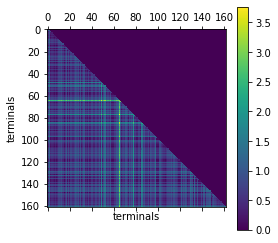

In [63]:
# Plot heatmap of cheapest path
plt.matshow(np.transpose(shortest_dist_mat))
plt.xlabel('terminals')
plt.ylabel('terminals')
plt.colorbar()

Text(0, 0.5, 'Number of pairs of terminals')

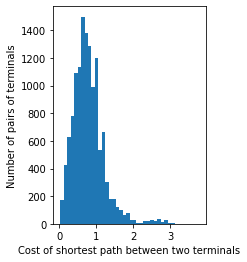

In [64]:
# Plot histogram of cheapest path
plt.subplot(1,2,1)
flat_mat = shortest_dist_mat[np.triu_indices(n_terminals, k=1)]
plt.hist(flat_mat,40)
plt.xlabel('Cost of shortest path between two terminals')
plt.ylabel('Number of pairs of terminals')

## G range

In [10]:
# Create a dictionary containing edge costs under several choices of g
g_range = [0,1,2,3,4,5]
edge_costs_dict={'g = -Inf': graph.edge_costs}
for g in g_range:
    params = {"w": 0, "b": 1, "g": g, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    graph._reset_hyperparameters(params)
    edge_costs_dict['g='+str(g)] = graph.costs
edge_costs_df = pd.DataFrame(data = edge_costs_dict)

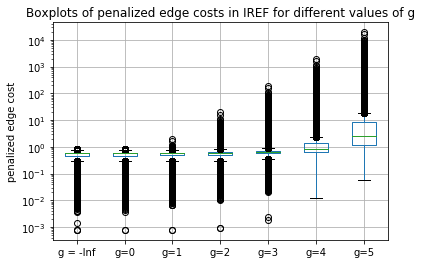

In [11]:
# Boxplot of edge costs under several choices of g
plt.figure()
edge_costs_df.boxplot()
plt.yscale('log')
plt.ylabel('penalized edge cost')
plt.title('Boxplots of penalized edge costs in IREF for different values of g')
plt.show()

## B range

In [12]:
# For a range of g, compute the maximum penalized edge cost
g_range = [0,1,2,3,4,5]
max_penalized_edge_cost = pd.DataFrame(edge_costs_df.max())
max_penalized_edge_cost.columns=['max_penalized_edge_cost']
max_penalized_edge_cost

,max_penalized_edge_cost
g = -Inf,0.859220
g=0,0.860892
g=1,2.015303
g=2,19.487738
g=3,194.212079
g=4,1941.455488
g=5,19413.889586


# Sensitivity analysis for Steiner tree parameters

## Run sensitivity analysis

In [13]:
# Load set of virus interacting genes from Gordon et al.
virus_partners_file_name = "../Data/SARSCov_targets_df.tsv"
virus_interacting_genes = sensitivity.import_virus_partners(virus_partners_file_name)

In [14]:
# Parameters for sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
W_list = np.linspace(start = 0.2, stop = 2, num = 10)
B_list = np.array([5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [21]:
# Run sensitivity analysis
networks_dict = sensitivity.run_sensitivity_analysis(interactome_file_name, 
                                                     prize_file_name, 
                                                     graph_params, 
                                                     W_list, 
                                                     B_list, 
                                                     G=0)

05:25:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:27 - OI2: INFO - []
05:25:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:27 - OI2: INFO - []


Progress= 0.01


05:25:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:27 - OI2: INFO - []
05:25:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:27 - OI2: INFO - []


Progress= 0.02


05:25:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:28 - OI2: INFO - []
05:25:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:28 - OI2: INFO - []


Progress= 0.03


05:25:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:29 - OI2: INFO - []
05:25:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:29 - OI2: INFO - []


Progress= 0.04


05:25:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:30 - OI2: INFO - []
05:25:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:30 - OI2: INFO - []


Progress= 0.05


05:25:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:30 - OI2: INFO - []
05:25:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:30 - OI2: INFO - []


Progress= 0.06


05:25:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:31 - OI2: INFO - []
05:25:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:31 - OI2: INFO - []


Progress= 0.07


05:25:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:32 - OI2: INFO - []
05:25:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:32 - OI2: INFO - []


Progress= 0.08


05:25:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:33 - OI2: INFO - []
05:25:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:33 - OI2: INFO - []


Progress= 0.09


05:25:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:33 - OI2: INFO - []
05:25:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:33 - OI2: INFO - []


Progress= 0.1


05:25:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:34 - OI2: INFO - []
05:25:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:34 - OI2: INFO - []


Progress= 0.11


05:25:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:35 - OI2: INFO - []
05:25:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:35 - OI2: INFO - []


Progress= 0.12


05:25:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:36 - OI2: INFO - []
05:25:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:36 - OI2: INFO - []


Progress= 0.13


05:25:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:37 - OI2: INFO - []
05:25:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:37 - OI2: INFO - []


Progress= 0.14


05:25:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:38 - OI2: INFO - []
05:25:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:38 - OI2: INFO - []


Progress= 0.15


05:25:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:39 - OI2: INFO - []
05:25:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:39 - OI2: INFO - []


Progress= 0.16


05:25:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:40 - OI2: INFO - []
05:25:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:40 - OI2: INFO - []


Progress= 0.17


05:25:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:41 - OI2: INFO - []
05:25:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:41 - OI2: INFO - []


Progress= 0.18


05:25:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:41 - OI2: INFO - []
05:25:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:41 - OI2: INFO - []


Progress= 0.19


05:25:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:42 - OI2: INFO - []
05:25:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:42 - OI2: INFO - []


Progress= 0.2


05:25:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:43 - OI2: INFO - []
05:25:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:43 - OI2: INFO - []


Progress= 0.21


05:25:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:44 - OI2: INFO - []
05:25:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:44 - OI2: INFO - []


Progress= 0.22


05:25:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:45 - OI2: INFO - []
05:25:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:45 - OI2: INFO - []


Progress= 0.23


05:25:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:46 - OI2: INFO - []
05:25:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:46 - OI2: INFO - []


Progress= 0.24


05:25:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:47 - OI2: INFO - []
05:25:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:47 - OI2: INFO - []


Progress= 0.25


05:25:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:48 - OI2: INFO - []
05:25:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:48 - OI2: INFO - []


Progress= 0.26


05:25:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:49 - OI2: INFO - []
05:25:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:49 - OI2: INFO - []


Progress= 0.27


05:25:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:50 - OI2: INFO - []
05:25:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:50 - OI2: INFO - []


Progress= 0.28


05:25:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:51 - OI2: INFO - []
05:25:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:51 - OI2: INFO - []


Progress= 0.29


05:25:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:52 - OI2: INFO - []
05:25:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:52 - OI2: INFO - []


Progress= 0.3


05:25:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:53 - OI2: INFO - []
05:25:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:53 - OI2: INFO - []


Progress= 0.31


05:25:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:55 - OI2: INFO - []
05:25:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:55 - OI2: INFO - []


Progress= 0.32


05:25:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:56 - OI2: INFO - []
05:25:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:56 - OI2: INFO - []


Progress= 0.33


05:25:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:57 - OI2: INFO - []
05:25:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:57 - OI2: INFO - []


Progress= 0.34


05:25:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:58 - OI2: INFO - []
05:25:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:58 - OI2: INFO - []


Progress= 0.35


05:25:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:59 - OI2: INFO - []
05:25:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:59 - OI2: INFO - []


Progress= 0.36


05:26:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:00 - OI2: INFO - []
05:26:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:00 - OI2: INFO - []


Progress= 0.37


05:26:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:01 - OI2: INFO - []
05:26:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:01 - OI2: INFO - []


Progress= 0.38


05:26:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:02 - OI2: INFO - []
05:26:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:02 - OI2: INFO - []


Progress= 0.39


05:26:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:03 - OI2: INFO - []
05:26:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:03 - OI2: INFO - []


Progress= 0.4


05:26:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:04 - OI2: INFO - []
05:26:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:04 - OI2: INFO - []


Progress= 0.41


05:26:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:05 - OI2: INFO - []
05:26:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:05 - OI2: INFO - []


Progress= 0.42


05:26:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:06 - OI2: INFO - []
05:26:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:06 - OI2: INFO - []


Progress= 0.43


05:26:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:07 - OI2: INFO - []
05:26:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:07 - OI2: INFO - []


Progress= 0.44


05:26:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:08 - OI2: INFO - []
05:26:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:08 - OI2: INFO - []


Progress= 0.45


05:26:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:09 - OI2: INFO - []
05:26:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:09 - OI2: INFO - []


Progress= 0.46


05:26:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:10 - OI2: INFO - []
05:26:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:10 - OI2: INFO - []


Progress= 0.47


05:26:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:11 - OI2: INFO - []
05:26:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:11 - OI2: INFO - []


Progress= 0.48


05:26:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:12 - OI2: INFO - []
05:26:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:12 - OI2: INFO - []


Progress= 0.49


05:26:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:13 - OI2: INFO - []
05:26:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:13 - OI2: INFO - []


Progress= 0.5


05:26:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:14 - OI2: INFO - []
05:26:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:14 - OI2: INFO - []


Progress= 0.51


05:26:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:15 - OI2: INFO - []
05:26:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:15 - OI2: INFO - []


Progress= 0.52


05:26:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:16 - OI2: INFO - []
05:26:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:16 - OI2: INFO - []


Progress= 0.53


05:26:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:17 - OI2: INFO - []
05:26:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:17 - OI2: INFO - []


Progress= 0.54


05:26:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:18 - OI2: INFO - []
05:26:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:18 - OI2: INFO - []


Progress= 0.55


05:26:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:19 - OI2: INFO - []
05:26:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:19 - OI2: INFO - []


Progress= 0.56


05:26:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:20 - OI2: INFO - []
05:26:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:20 - OI2: INFO - []


Progress= 0.57


05:26:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:21 - OI2: INFO - []
05:26:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:21 - OI2: INFO - []


Progress= 0.58


05:26:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:22 - OI2: INFO - []
05:26:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:22 - OI2: INFO - []


Progress= 0.59


05:26:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:24 - OI2: INFO - []
05:26:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:24 - OI2: INFO - []


Progress= 0.6


05:26:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:25 - OI2: INFO - []
05:26:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:25 - OI2: INFO - []


Progress= 0.61


05:26:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:26 - OI2: INFO - []
05:26:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:26 - OI2: INFO - []


Progress= 0.62


05:26:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:27 - OI2: INFO - []
05:26:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:27 - OI2: INFO - []


Progress= 0.63


05:26:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:28 - OI2: INFO - []
05:26:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:28 - OI2: INFO - []


Progress= 0.64


05:26:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:29 - OI2: INFO - []
05:26:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:29 - OI2: INFO - []


Progress= 0.65


05:26:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:30 - OI2: INFO - []
05:26:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:30 - OI2: INFO - []


Progress= 0.66


05:26:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:31 - OI2: INFO - []
05:26:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:31 - OI2: INFO - []


Progress= 0.67


05:26:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:32 - OI2: INFO - []
05:26:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:32 - OI2: INFO - []


Progress= 0.68


05:26:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:33 - OI2: INFO - []
05:26:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:33 - OI2: INFO - []


Progress= 0.69


05:26:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:34 - OI2: INFO - []
05:26:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:34 - OI2: INFO - []


Progress= 0.7


05:26:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:35 - OI2: INFO - []
05:26:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:35 - OI2: INFO - []


Progress= 0.71


05:26:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:36 - OI2: INFO - []
05:26:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:36 - OI2: INFO - []


Progress= 0.72


05:26:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:37 - OI2: INFO - []
05:26:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:37 - OI2: INFO - []


Progress= 0.73


05:26:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:38 - OI2: INFO - []
05:26:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:38 - OI2: INFO - []


Progress= 0.74


05:26:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:39 - OI2: INFO - []
05:26:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:39 - OI2: INFO - []


Progress= 0.75


05:26:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:40 - OI2: INFO - []
05:26:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:40 - OI2: INFO - []


Progress= 0.76


05:26:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:41 - OI2: INFO - []
05:26:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:41 - OI2: INFO - []


Progress= 0.77


05:26:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:42 - OI2: INFO - []
05:26:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:42 - OI2: INFO - []


Progress= 0.78


05:26:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:43 - OI2: INFO - []
05:26:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:43 - OI2: INFO - []


Progress= 0.79


05:26:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:44 - OI2: INFO - []
05:26:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:44 - OI2: INFO - []


Progress= 0.8


05:26:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:45 - OI2: INFO - []
05:26:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:45 - OI2: INFO - []


Progress= 0.81


05:26:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:46 - OI2: INFO - []
05:26:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:46 - OI2: INFO - []


Progress= 0.82


05:26:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:47 - OI2: INFO - []
05:26:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:47 - OI2: INFO - []


Progress= 0.83


05:26:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:48 - OI2: INFO - []
05:26:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:48 - OI2: INFO - []


Progress= 0.84


05:26:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:49 - OI2: INFO - []
05:26:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:49 - OI2: INFO - []


Progress= 0.85


05:26:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:51 - OI2: INFO - []
05:26:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:51 - OI2: INFO - []


Progress= 0.86


05:26:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:52 - OI2: INFO - []
05:26:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:52 - OI2: INFO - []


Progress= 0.87


05:26:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:53 - OI2: INFO - []
05:26:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:53 - OI2: INFO - []


Progress= 0.88


05:26:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:54 - OI2: INFO - []
05:26:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:54 - OI2: INFO - []


Progress= 0.89


05:26:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:55 - OI2: INFO - []
05:26:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:55 - OI2: INFO - []


Progress= 0.9


05:26:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:56 - OI2: INFO - []
05:26:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:56 - OI2: INFO - []


Progress= 0.91


05:26:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:57 - OI2: INFO - []
05:26:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:57 - OI2: INFO - []


Progress= 0.92


05:26:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:58 - OI2: INFO - []
05:26:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:58 - OI2: INFO - []


Progress= 0.93


05:26:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:59 - OI2: INFO - []
05:26:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:59 - OI2: INFO - []


Progress= 0.94


05:27:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:00 - OI2: INFO - []
05:27:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:00 - OI2: INFO - []


Progress= 0.95


05:27:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:01 - OI2: INFO - []
05:27:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:01 - OI2: INFO - []


Progress= 0.96


05:27:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:02 - OI2: INFO - []
05:27:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:02 - OI2: INFO - []


Progress= 0.97


05:27:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:03 - OI2: INFO - []
05:27:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:03 - OI2: INFO - []


Progress= 0.98


05:27:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:04 - OI2: INFO - []
05:27:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:04 - OI2: INFO - []


Progress= 0.99


05:27:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:05 - OI2: INFO - []
05:27:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:05 - OI2: INFO - []


Progress= 1.0


In [22]:
# Save as pickle
with open("../Save/networks_dict.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [15]:
# Add metatadata
networks_dict = pickle.load(open("../Save/networks_dict.pkl", "rb"))
networks_dict = sensitivity.add_metadata(networks_dict, virus_interacting_genes)

In [16]:
# Make summary
networks_summary_df = sensitivity.make_summary(networks_dict, n_terminals, g=0)
networks_summary_df.head()

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals,upregulated_terminals,downregulated_terminals,number_transcription_regulators,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
w_0.2_b_10.0,1,0.2,10.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_15.0,2,0.2,15.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_20.0,3,0.2,20.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_25.0,4,0.2,25.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_30.0,5,0.2,30.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"


## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

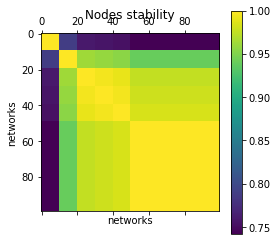

In [25]:
# Stability of selected nodes
mat_allnodes = sensitivity.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

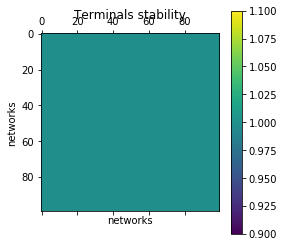

In [26]:
# Stability of selected terminals
mat_terminals = sensitivity.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

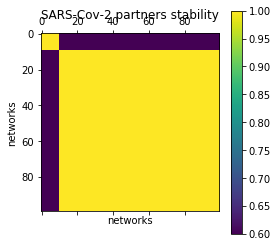

In [27]:
# Stability of selected SARS-Cov-2 partners
mat_sars = sensitivity.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [17]:
# Select network corresponding to g=0, w=1.4 and b=40
index_selected = 67
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected = networks_dict[paramstring_selected]

In [18]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected, filename="../Save/network_selected.html")
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save/network_selected.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(robust_network, filename= '../Save/network_selected.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save/network_selected.pickle')

# Sensitivity analysis for virus partners prize

## Run sensitivity analysis

In [30]:
# Identify which SARS-Cov-2 partners are in the terminal list
terminal_partners = set(terminals).intersection(virus_interacting_genes)
print(terminal_partners)

{'EXOSC5', 'LOX', 'FOXRED2'}


In [31]:
# Run sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0,
                "w": 1.4,
                "b": 40,
                "g": 0
                }
# List of values of P
P_list = np.arange(0,0.0016,0.0001)

networks_dict = svp.run_prize_sensitivity_analysis(interactome_file_name, 
                                                   prize_file_name, 
                                                   graph_params, 
                                                   virus_interacting_genes, 
                                                   terminal_partners, 
                                                   P_list)

05:29:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:46 - OI2: INFO - []
05:29:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:46 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.0625


05:29:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:47 - OI2: INFO - []
05:29:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:47 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.125


05:29:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:49 - OI2: INFO - []
05:29:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:49 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.1875


05:29:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:50 - OI2: INFO - []
05:29:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:50 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.25


05:29:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:52 - OI2: INFO - []
05:29:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:52 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.3125


05:29:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:53 - OI2: INFO - []
05:29:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:53 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.375


05:29:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:55 - OI2: INFO - []
05:29:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:55 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.4375


05:29:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:56 - OI2: INFO - []
05:29:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:56 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5


05:29:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:58 - OI2: INFO - []
05:29:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:58 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5625


05:30:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:00 - OI2: INFO - []
05:30:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:00 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.625


05:30:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:01 - OI2: INFO - []
05:30:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:01 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.6875


05:30:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:03 - OI2: INFO - []
05:30:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:03 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.75


05:30:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:04 - OI2: INFO - []
05:30:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:04 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.8125


05:30:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:06 - OI2: INFO - []
05:30:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:06 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.875


05:30:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:07 - OI2: INFO - []
05:30:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:07 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.9375


05:30:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:09 - OI2: INFO - []
05:30:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:09 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 1.0


In [32]:
# Save as pickle
with open("../Save/networks_dict_sarspartners.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [33]:
# Add metadata
networks_dict = pickle.load(open("../Save/networks_dict_sarspartners.pkl", "rb"))
networks_dict = svp.add_metadata(networks_dict, virus_interacting_genes)

In [34]:
# Make summary
networks_summary_df = svp.make_summary(networks_dict, n_terminals)
networks_summary_df.head()

,index,p,nodes,edges,number_components,size_components,percentage_terminals,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
p_0.0,0,0.0,252,1003,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0001,1,0.0001,252,1003,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0002,2,0.0002,251,998,1,[251],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.00030000000000000003,3,0.00030000000000000003,252,1011,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",6,"[CUL2, EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0004,4,0.0004,255,1081,1,[255],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",7,"[CUL2, EXOSC5, FOXRED2, HDAC2, LOX, RBX1, RIPK1]"


## Plot number of SARS-Cov-2 partners picked up versus p

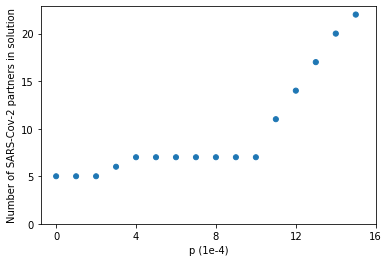

In [35]:
plt.figure()
plt.scatter(x = networks_summary_df['p'], 
            y = networks_summary_df['number_of_proteins_interacting_sars'],
            s = 0.1*networks_summary_df['nodes'])
plt.xlabel('p (1e-4)')
plt.ylabel('Number of SARS-Cov-2 partners in solution')
plt.xticks(np.arange(0,17,4),['0','4','8','12','16'])
plt.yticks(np.arange(0,25,5))
plt.show()

## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

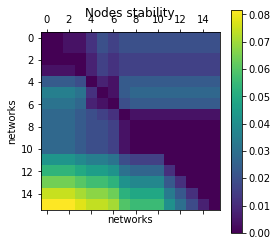

In [36]:
# Stability of selected nodes
mat_allnodes = svp.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

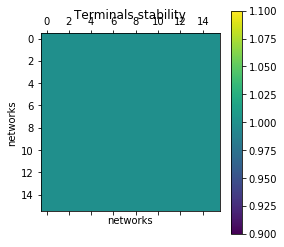

In [66]:
# Stability of selected terminals
mat_terminals = svp.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

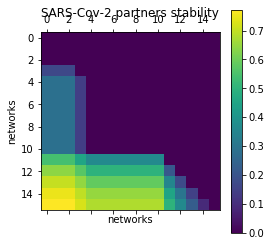

In [67]:
# Stability of selected SARS-Cov-2 partners
mat_sars = svp.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [39]:
# Save network
index_selected = 8
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected2 = networks_dict[paramstring_selected]

In [40]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected2, filename="../Save/network_selected_sarspartners.html")
oi.output_networkx_graph_as_pickle(network_selected2, filename= '../Save/network_selected_sarspartners.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(network_selected, filename= r'../Save/network_selected_sarspartners.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save/network_selected_sarspartners.pickle')

# Add drug targets to selected network

## Load DrugCentral data

In [19]:
# Compute degree centrality for all nodes in the interactome
graph = oi.Graph(interactome_file_name)
centrality_dic = nx.degree_centrality(graph.interactome_graph)

In [20]:
# Load drug/target data from DrugCentral
drug_target_file_name = '../Data/drug.target.interaction.tsv'
drugcentral_df = drugs2.load_drug_target_data(drug_target_file_name, aff_cst_thresh=5)
drugcentral_df['degree_centrality'] = [centrality_dic[gene] if (gene in list(centrality_dic.keys())) else None for gene in drugcentral_df['gene']]
drugcentral_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality
0,SCN4A,levobupivacaine,Sodium channel protein type 4 subunit alpha,NaN,NaN,0.000635
1,CYP2D6,levobupivacaine,Cytochrome P450 2D6,6.706859,IC50,NaN
4,PTGER1,levobupivacaine,Prostaglandin E2 receptor EP1 subtype,NaN,NaN,0.000317
5,SCN1A,levobupivacaine,Sodium channel protein type 1 subunit alpha,5.790000,IC50,0.000254
6,KCNA5,levobupivacaine,Potassium voltage-gated channel subfamily A me...,NaN,NaN,0.002031


## Number of targets per drug

In [21]:
# Construct table that gives the number of targets per drug
num_targets_df0 = drugcentral_df.groupby('drug', as_index=False)[['gene']].agg({
    ('num_targets','count'),
    ('num_terminal_targets',lambda gs: len(set(gs).intersection(set(terminals))))
})
max_centrality_df0 = drugcentral_df.groupby('drug', as_index=False)[['degree_centrality']].agg({
    ('max_degree_centrality',max)
})
num_targets_df = pd.DataFrame({'drug': num_targets_df0.index,
                               'num_targets': num_targets_df0['gene']['num_targets'],
                               'num_terminal_targets': num_targets_df0['gene']['num_terminal_targets'],
                               'max_target_centrality': max_centrality_df0['degree_centrality']['max_degree_centrality']}).reset_index(drop=True)
num_targets_df = num_targets_df.sort_values(by='num_targets', ascending=False, inplace=False)
num_targets_df.head(10)

,drug,num_targets,num_terminal_targets,max_target_centrality
1830,sunitinib,260,4,0.055718
1369,nintedanib,218,3,0.037187
1269,midostaurin,204,3,0.055718
259,bosutinib,203,1,0.055718
474,crizotinib,148,3,0.055718
1735,ruxolitinib,132,1,0.027224
508,dasatinib,129,2,0.055718
1730,ruboxistaurin,121,1,0.055718
1795,sorafenib,116,4,0.037187
2031,vandetanib,109,3,0.055718


DescribeResult(nobs=2095, minmax=(1, 260), mean=6.18090692124105, variance=205.24089602523858, skewness=9.430834744443953, kurtosis=121.23217572880604)

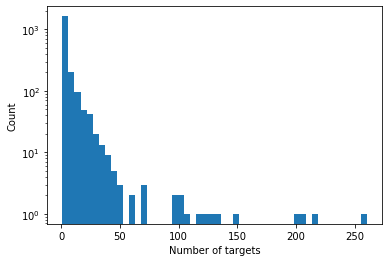

In [50]:
# Histogram of number of targets per drug
plt.figure()
plt.hist(num_targets_df['num_targets'],50)
plt.yscale('log')
plt.xlabel('Number of targets')
plt.ylabel('Count')
plt.plot()
ss.describe(num_targets_df['num_targets'])

## Load L1000 correlation-scored drugs

In [2]:
# Load L1000 drugs with correlations
embedded_drugs_file_name = '../Data/final_A549_drug_correlations.csv'
bestdrugs_df = drugs2.load_embedded_drugs(embedded_drugs_file_name, lower_corr_thresh=0.86)
bestdrugs_df.head()

,drug,corr
0,doxapram,0.882798
1,dasatinib,0.882561
2,cyproheptadine,0.882541
3,ribavirin,0.881823
4,ethambutol,0.881799


In [4]:
len(bestdrugs_df)

142

## Merge high-anticorrelation drugs with DrugCentral dataset

In [37]:
# Merge L1000 drugs with DrugCentral drug/target dataset
targets_and_drugs_df = drugcentral_df.merge(bestdrugs_df, on = 'drug', how = 'inner')
targets_and_drugs_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality,corr
0,RARA,acitretin,Retinoic acid receptor alpha,NaN,NaN,0.008821,0.869150
1,RARG,acitretin,Retinoic acid receptor gamma,NaN,NaN,0.002285,0.869150
2,CYP19A1,aminoglutethimide,Aromatase,5.110000,IC50,0.000063,0.860848
3,CYP11A1,aminoglutethimide,"Cholesterol side-chain cleavage enzyme, mitoch...",NaN,NaN,0.000317,0.860848
4,ADRA2A,amitriptyline,Alpha-2A adrenergic receptor,6.879426,Ki,0.000762,0.872172


In [41]:
# Compute proportion of drugs in the intersection that are tinibs
tinib_drugs = np.unique(targets_and_drugs_df.set_index('drug').filter(like='tinib', axis=0).index)
all_drugs = np.unique(targets_and_drugs_df['drug'])
prop_tinib = len(tinib_drugs)/len(all_drugs)
prop_tinib

0.07692307692307693

In [45]:
# Number of targets for tinib drugs
num_targets_df.loc[num_targets_df['drug'].isin(np.unique(tinib_drugs))]

,drug,num_targets,num_terminal_targets,max_target_centrality
1830,sunitinib,260,4,0.055718
259,bosutinib,203,1,0.055718
1735,ruxolitinib,132,1,0.027224
508,dasatinib,129,2,0.055718
167,axitinib,99,3,0.055718
719,erlotinib,96,2,0.055718
991,imatinib,70,0,0.055718
1938,tofacitinib,43,0,0.020434
43,afatinib,38,1,0.055718


## Add drug target information to selected network

In [24]:
network_selected = pickle.load(open('../Save/network_selected.pickle', "rb"))
network_selected = drugs2.add_drug_info_to_selected_network(network_selected, targets_and_drugs_df)
# Save enriched network as pickle
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save/network_selected_with_drug_info.pickle')

PosixPath('/home/louiscam/projects/sars_cov_2/Save/network_selected_with_drug_info.pickle')

In [44]:
# Construct table of drug targets in the network
drug_targets_df = drugs2.drug_targets_in_selected_network(network_selected)
drug_targets_df.to_csv(r'../Save/drug_targets_in_network.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
drug_targets_df['affinity'] = pd.to_numeric(drug_targets_df['affinity'], errors='coerce')
drug_targets_df.dropna(subset=['affinity'], inplace=True)
drug_targets_df['terminal'] = drug_targets_df['name'].isin(terminals)
drug_targets_df

,name,protein_target,drug,corr,affinity,terminal
ACVR2A,ACVR2A,{Activin receptor type-2A},dasatinib,0.88256145,6.6800,False
AURKC,AURKC,{Aurora kinase C},erlotinib,0.8737799,6.2200,True
AURKC,AURKC,{Aurora kinase C},sorafenib,0.86517066,6.6800,True
AURKC,AURKC,{Aurora kinase C},sunitinib,0.8685898,6.6600,True
AURKC,AURKC,{Aurora kinase C},pazopanib,0.86695886,6.1200,True
AURKC,AURKC,{Aurora kinase C},ruxolitinib,0.87487674,5.0600,True
AURKC,AURKC,{Aurora kinase C},axitinib,0.8779775,8.8900,True
BRSK1,BRSK1,{Serine/threonine-protein kinase BRSK1},sunitinib,0.8685898,5.4600,True
CDK17,CDK17,{Cyclin-dependent kinase 17},sorafenib,0.86517066,5.8000,True
CDK17,CDK17,{Cyclin-dependent kinase 17},sunitinib,0.8685898,5.9200,True


In [26]:
# Save drug/target dataframe to csv
drug_targets_df.to_csv(r'../Save/final_drug_target_table.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

In [27]:
# More details on selected drugs
num_targets_df.loc[num_targets_df['drug'].isin(np.unique(drug_targets_df['drug']))]

,drug,num_targets,num_terminal_targets,max_target_centrality
1830,sunitinib,260,4,0.055718
259,bosutinib,203,1,0.055718
1735,ruxolitinib,132,1,0.027224
508,dasatinib,129,2,0.055718
1795,sorafenib,116,4,0.037187
1479,pazopanib,104,3,0.028430
167,axitinib,99,3,0.055718
719,erlotinib,96,2,0.055718
991,imatinib,70,0,0.055718
1938,tofacitinib,43,0,0.020434


# Plot neighborhood graphs

In [46]:
# Load selected network
network_selected = pickle.load(open("../Save/network_selected_with_drug_info.pickle", "rb"))

In [47]:
# Add edge confidence to attributes
nbh.add_edge_confidence(network_selected)

In [48]:
# Color map bounds for nodes
min_prize = np.floor(min(nx.get_node_attributes(network_selected,'log2FC_blanco').values()))
max_prize = np.floor(max(nx.get_node_attributes(network_selected,'log2FC_blanco').values()))+1
vmin_nodes = -max(abs(min_prize),abs(max_prize))
vmax_nodes = max(abs(min_prize),abs(max_prize))

In [49]:
# Dictionary of nodes of interest with corresponding cost threshold (Figure 4c)
node_to_cost_thresh_4c = {
    'EXOSC5': 0.53,
    'FOXRED2': 1,
    'LOX': 0.58,
    'RBX1': 0.53,
    'RIPK1': 0.53,
    'HDAC1':0.53
}

# Dictionary of nodes of interest with corresponding cost threshold (Figure Supp_fig_4_6)
node_to_cost_thresh_46 = {
    'CUL2': 0.53,
    'EXOSC5': 0.53,
    'FOXRED2': 1,
    'LOX': 0.58,
    'RBX1': 0.53,
    'RIPK1': 0.53,
    'HDAC1': 0.53,
    'HDAC2': 0.53
}

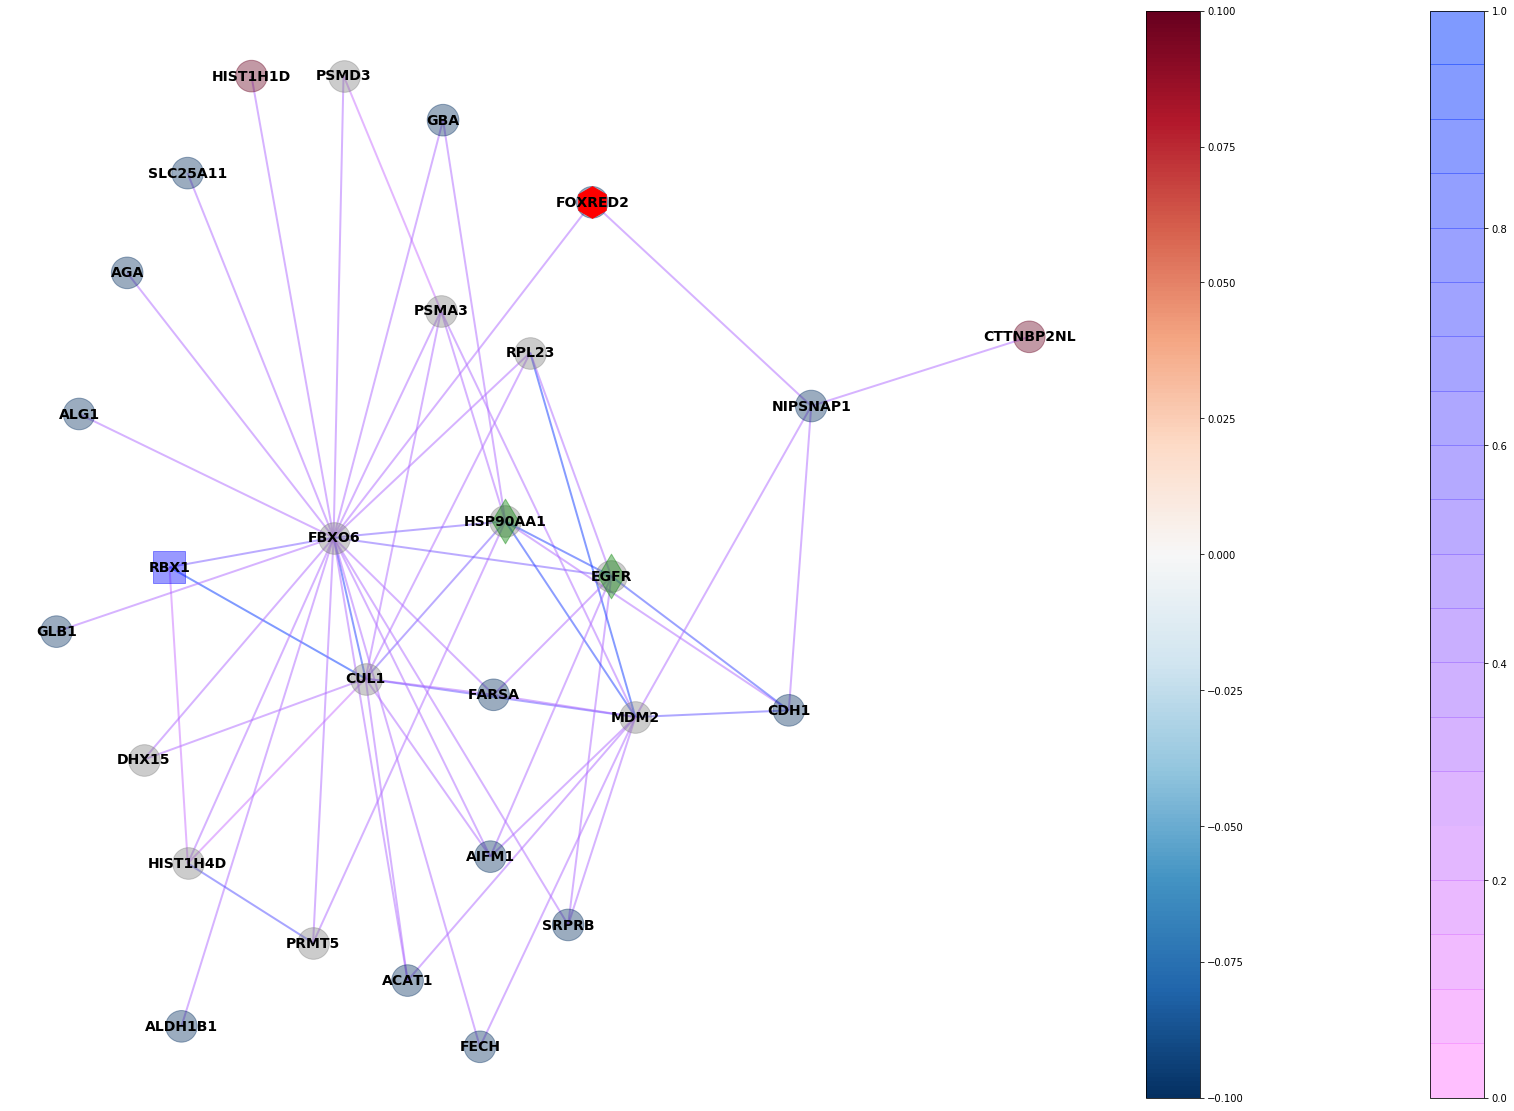

In [51]:
# Plot neighborhood of protein_center
protein_center = 'FOXRED2'
cthreshold = node_to_cost_thresh_4c[protein_center]
nbh.plot_neighborhood_subnetwork(protein_center,
                                 network_selected,
                                 vmin_nodes,
                                 vmax_nodes,
                                 vmin_edges = 0,
                                 vmax_edges = 1,
                                 removeUBC = True, 
                                 cthreshold = cthreshold, 
                                 nodesize = 1000,
                                 save=False)